In [1]:
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pyodbc
import pymssql
import sqlalchemy
from shapely import wkt
import ogr
import json
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.tile_providers import get_provider, Vendors
from bokeh.plotting import figure, output_file, show

In [8]:
#load 2019 data
data_path = r'\\AWS-Model10\Model Data 2\INRIX'
os.chdir(data_path)

In [11]:
trips_header = pd.read_csv(os.path.join(r'\\AWS-Model10\Model Data 2\INRIX\trip_paths_usa_wa_puget_sound_201905\date=2020-12-29\reportId=45749\v1', 'schema', 'TripBulkReportTripsHeaders.csv'))
trips_df = pd.read_csv(os.path.join(r'\\AWS-Model10\Model Data 2\INRIX\trip_paths_usa_wa_puget_sound_201905\date=2020-12-29\reportId=45749\v1\data\trips\trips.csv.gz'), 
                       compression='gzip', names = trips_header.columns)

In [12]:
pd.set_option('display.max_columns', None)
trips_df.head()

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,EndLocLat,EndLocLon,GeospatialType,ProviderType,ProviderDrivingProfile,VehicleWeightClass,ProbeSourceType,OriginZoneName,DestinationZoneName,EndpointType,TripMeanSpeedKph,TripMaxSpeedKph,TripDistanceMeters,MovementType,OriginCbg,DestCbg,StartTimezone,EndTimezone,WaypointFreqSec,StartQk,EndQk
0,a58741e59c39b039c50101f68d292349,d422c29ef06ec8dc7a3ad73858c1c70e,f033ab37c30201f73f142449d037028d,1,2019-05-20T22:53:34.034Z,1,2019-05-20T23:02:03.003Z,1,48.0001,-122.1159,48.0004,-122.1272,II,2,3,2,1,SNOHOMISH,SNOHOMISH,2,26.555007,54.345351,3754.354248,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,46.269909,21230012232320301,21230012232231301
1,e574a35bb513e4981424188726e9662a,1992ccba0a2d60701d03880371fdde6c,f033ab37c30201f73f142449d037028d,1,2019-05-20T23:59:59.059Z,1,2019-05-21T00:05:29.029Z,1,48.0545,-122.1876,48.0767,-122.1878,II,2,3,2,1,SNOHOMISH,SNOHOMISH,3,38.949262,94.146654,3570.024483,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,12.691154,21230012221332003,21230012221310003
2,fc7f4fe52cb94479ae9f7e5f6702e4de,93f7fc1ffabe1538010794e907f1703f,54229abfcfa5649e7003b83dd4755294,1,2019-05-21T15:22:48.048Z,2,2019-05-21T15:24:27.027Z,2,47.2385,-122.3682,47.2345,-122.3645,II,2,3,2,1,PIERCE,PIERCE,2,19.756351,21.541364,543.184395,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,24.744750,21230023311303132,21230023311312222
3,88ed8f34f208ec74ff05272fd57ebe12,fcc676d1dc8eeececfc8251a08a47913,54229abfcfa5649e7003b83dd4755294,1,2019-05-21T19:36:31.031Z,2,2019-05-21T20:06:33.033Z,2,47.4535,-122.2233,47.2098,-122.3003,II,2,3,2,1,KING,PIERCE,3,66.460610,95.820417,33267.264305,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,78.347913,21230032003010311,21230032202013131
4,1e9e9c070524cb976e5be7a0009197bb,fba11305da03375db0e7d26e2d69dcf5,f033ab37c30201f73f142449d037028d,1,2019-05-21T22:12:30.030Z,2,2019-05-21T22:22:29.029Z,2,47.9183,-122.1091,47.9359,-122.0796,II,2,3,2,1,SNOHOMISH,SNOHOMISH,3,28.006599,84.247798,4659.979105,1,NaN,NaN,America/Los_Angeles,America/Los_Angeles,59.899900,21230030012103212,21230030011222020


In [14]:
trips_header_2015 = pd.read_csv(os.path.join(r'\\AWS-Model10\Model Data 2\INRIX\trip_paths_usa_wa_puget_sound_201505\date=2020-12-29\reportId=45748\v1', 'schema', 'TripBulkReportTripsHeaders.csv'))
trips_df_2015 = pd.read_csv(os.path.join(r'\\AWS-Model10\Model Data 2\INRIX\trip_paths_usa_wa_puget_sound_201505\date=2020-12-29\reportId=45748\v1\data\trips\trips.csv.gz'), 
                       compression='gzip', names = trips_header.columns)

In [5]:
#number of trips recroded in 2019
len(pd.unique(trips_df['TripId'])) 

1242924

In [15]:
#number of trips recroded in 2015
len(pd.unique(trips_df_2015['TripId'])) 

1179583

Vehicle types in the dataset
VehicleWeightClass - Lists one of three weight classes provider
    1 = Light Duty Truck/Passenger Vehicle: Ranges from 0 to 14,000 lb.
    2 = Medium Duty Trucks / Vans: ranges from 14001–26000 lb.
    3 = Heavy Duty Trucks: > 26000 lb.

In [10]:
#trips by vehicle class in 2019
trips_df.groupby('VehicleWeightClass').size()

VehicleWeightClass
2    1013601
3     229334
dtype: int64

In [16]:
#trips by vehicle class in 2019
trips_df_2015.groupby('VehicleWeightClass').size()

VehicleWeightClass
2    841373
3    338223
dtype: int64

Provider types and Provider driver profile
ProviderType - Describes the provider type
    1 = Consumer
    2 = Fleet
ProviderDrivingProfile -  Driving class, additional detail about type of provider
    1 = Consumer Vehicles
    2 = Taxi/shuttle/town car services
    3 = Field Service/Local Delivery Fleets
    4 = For hire/private trucking fleets

In [11]:
trips_df.groupby('ProviderType').size()
trips_df.groupby('ProviderDrivingProfile').size()

ProviderDrivingProfile
3    1013601
4     229334
dtype: int64

In [17]:
trips_df_2015.groupby('ProviderType').size()
trips_df_2015.groupby('ProviderDrivingProfile').size()

ProviderDrivingProfile
3    841373
4    338223
dtype: int64

Data covers the following dates in 2019:
May 1st - 31st 2019
Number of trips during an average weekday ~47-55k
Number of trips during an average weekend ~9-18k


in 2015:
May 1st - 31st 2015
Number of trips during an average weekday ~41-69k
Number of trips during an average weekend ~11-24k


In [30]:
trips_df.dtypes

TripId                                 object
DeviceId                               object
ProviderId                             object
Mode                                    int64
StartDate                              object
StartWDay                               int64
EndDate                                object
EndWDay                                 int64
StartLocLat                           float64
StartLocLon                           float64
EndLocLat                             float64
EndLocLon                             float64
GeospatialType                         object
ProviderType                            int64
ProviderDrivingProfile                  int64
VehicleWeightClass                      int64
ProbeSourceType                         int64
OriginZoneName                         object
DestinationZoneName                    object
EndpointType                            int64
TripMeanSpeedKph                      float64
TripMaxSpeedKph                   

In [18]:
trips_df['StartDate_upd'] = pd.to_datetime(trips_df["StartDate"])
trips_df["StartDate_dmy"] = trips_df["StartDate_upd"].apply(lambda x: x.strftime('%d%m%Y'))

trips_df_2015['StartDate_upd'] = pd.to_datetime(trips_df_2015["StartDate"])
trips_df_2015["StartDate_dmy"] = trips_df_2015["StartDate_upd"].apply(lambda x: x.strftime('%d%m%Y'))

In [19]:
trips_df["StartDOW"] = trips_df["StartDate_upd"].apply(lambda x: x.strftime('%A'))
trips_df_2015["StartDOW"] = trips_df_2015["StartDate_upd"].apply(lambda x: x.strftime('%A'))


In [20]:
df_test = trips_df.groupby(["StartDate_dmy","StartDOW"]).size()
df_test_2015 = trips_df_2015.groupby(["StartDate_dmy","StartDOW"]).size()

In [21]:
df_test = pd.DataFrame(df_test)
df_test_2015 = pd.DataFrame(df_test_2015)


In [23]:
df_test

,,0
StartDate_dmy,StartDOW,
01052019,Wednesday,51825
02052019,Thursday,51361
03052019,Friday,49319
04052019,Saturday,17639
05052019,Sunday,10125
06052019,Monday,47064
07052019,Tuesday,51382
08052019,Wednesday,52326
09052019,Thursday,52121


In [24]:
df_test_2015

,,0
StartDate_dmy,StartDOW,
01052015,Friday,45601
02052015,Saturday,19178
03052015,Sunday,11155
04052015,Monday,44595
05052015,Tuesday,46744
06052015,Wednesday,49607
07052015,Thursday,46395
08052015,Friday,43571
09052015,Saturday,19006


In [25]:
def read_from_sde(connection_string, feature_class_name,
                  crs={'init': 'epsg:2285'}):
    """
    Returns the specified feature class as a geodataframe from ElmerGeo.
    
    Parameters
    ----------
    connection_string : SQL connection string that is read by geopandas 
                        read_sql function
    
    feature_class_name: the name of the featureclass in PSRC's ElmerGeo 
                        Geodatabase
    
    cs: cordinate system
    """

    engine = sqlalchemy.create_engine(connection_string)
    con=engine.raw_connection()
    feature_class_name = feature_class_name + '_evw'
    df=pd.read_sql('select *, Shape.STAsText() as geometry from %s' % 
                   (feature_class_name), con=con)
    con.close()
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf=gpd.GeoDataFrame(df, geometry='geometry')
    gdf.crs = crs
    cols = [col for col in gdf.columns if col not in 
            ['Shape', 'GDB_GEOMATTR_DATA', 'SDE_STATE_ID']]
    
    return gdf[cols]

In [26]:
gdb_connection_string = 'mssql+pyodbc://AWS-PROD-SQL\Sockeye/OSMTest?driver=SQL Server?Trusted_Connection=yes'
name = 'ElmerGeo.DBO.tract2010'
tracts = read_from_sde(gdb_connection_string,name )

C:\Users\pbutrina\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [27]:
gdb_connection_string = 'mssql+pyodbc://AWS-PROD-SQL\Sockeye/OSMTest?driver=SQL Server?Trusted_Connection=yes'
name = 'ElmerGeo.DBO.urban_centers'
urban_centers = read_from_sde(gdb_connection_string,name )

In [ ]:
trips_d = gpd.GeoDataFrame(
    trips_df, geometry=gpd.points_from_xy(trips_df.EndLocLon, trips_df.EndLocLat))
trips_d.crs = "EPSG:4326"

trips_d_2015 = gpd.GeoDataFrame(
    trips_df_2015, geometry=gpd.points_from_xy(trips_df_2015.EndLocLon, trips_df_2015.EndLocLat))
trips_d_2015.crs = "EPSG:4326"


In [31]:
trips_o = gpd.GeoDataFrame(
    trips_df, geometry=gpd.points_from_xy(trips_df.StartLocLon, trips_df.StartLocLat))
trips_o.crs = "EPSG:4326"

trips_o_2015 = gpd.GeoDataFrame(
    trips_df_2015, geometry=gpd.points_from_xy(trips_df_2015.StartLocLon, trips_df_2015.StartLocLat))
trips_o_2015.crs = "EPSG:4326"

In [40]:
tracts = tracts.to_crs(epsg=4326)
urban_centers = urban_centers.to_crs(epsg=4326)

In [33]:
urban_centers.head()

,OBJECTID,id,name,area_feet,perimeter_,parking,popden1996,planpop96,jobs1994,planjobs94,houseunits,huplan,floorspc,acres,hectares,area,perimeter,adoptdate,category,geometry
0,20,21.0,Puyallup Downtown,9.365721e+06,13770.044,1187.0,1324.0,0.0,0.0,0.0,653.0,0.0,0.55,215.310376,87.011,215.310376,13770.044,,Urban,"POLYGON ((1275872.510 74753.492, 1275867.337 7..."
1,1,0.0,Seattle South Lake Union,1.563752e+07,19201.172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,359.492008,145.277,359.492008,19201.172,2004,Metro,"POLYGON ((1267990.947 229284.150, 1268257.266 ..."
2,13,12.0,Lynnwood,3.326289e+07,36627.868,0.0,2681.0,3813.0,9521.0,16940.0,1310.0,1882.0,5.92,763.613860,309.024,763.613860,36627.868,,Urban,"POLYGON ((1280095.500 302912.094, 1280090.000 ..."
3,433,14.0,Bothell Canyon Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,563.147324,NaN,NaN,NaN,None,Urban,"POLYGON ((1300032.220 292195.002, 1300032.220 ..."
4,8,7.0,Seattle First Hill/Capitol Hill,3.984466e+07,31626.325,0.0,28975.0,35440.0,33393.0,45093.0,20726.0,26266.0,0.00,914.711328,370.171,914.711328,31626.325,,Metro,"POLYGON ((1271488.236 228309.183, 1271474.445 ..."


InvalidLatitudeError: Y can not be computed: lat=90.00000000001

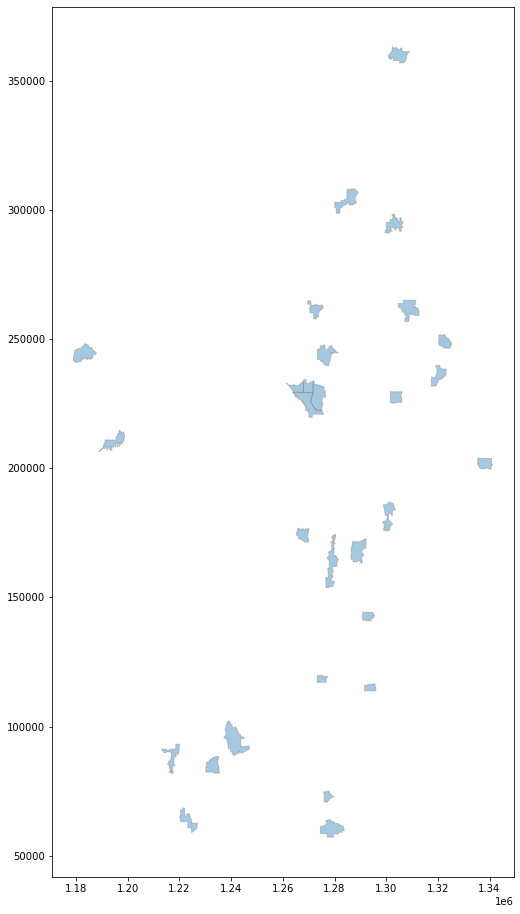

In [35]:
uc_plot = urban_centers.plot(figsize=(9, 16), zorder=10, ec='gray', alpha=0.4)
ctx.add_basemap(uc_plot, source=ctx.providers.Stamen.Terrain, zoom=10, alpha=0.6, zorder=8 , crs='EPSG:4326' )

In [69]:
tract_trips_o = gpd.sjoin(tracts, trips_o, how='inner', op='intersects')
tract_trips_d = gpd.sjoin(tracts, trips_d, how='inner', op='intersects')

tract_trips_o_2015 = gpd.sjoin(tracts, trips_o_2015, how='inner', op='intersects')
tract_trips_d_2015 = gpd.sjoin(tracts, trips_d_2015, how='inner', op='intersects')

In [70]:
uc_trips_o = gpd.sjoin(urban_centers, trips_o, how='inner', op='intersects')
uc_trips_d = gpd.sjoin(urban_centers, trips_d, how='inner', op='intersects')

In [71]:
tract_trips_o=tract_trips_o.groupby('namelsad10')['namelsad10'].count().reset_index(name='count').sort_values(by=['count'])
tract_trips_d=tract_trips_d.groupby('namelsad10')['namelsad10'].count().reset_index(name='count').sort_values(by=['count'])

In [72]:
tract_trips_o_2015=tract_trips_o_2015.groupby('namelsad10')['namelsad10'].count().reset_index(name='count').sort_values(by=['count'])
tract_trips_d_2015=tract_trips_d_2015.groupby('namelsad10')['namelsad10'].count().reset_index(name='count').sort_values(by=['count'])

In [73]:
uc_trips_o=uc_trips_o.groupby('name')['name'].count().reset_index(name='count').sort_values(by=['count'])
uc_trips_d=uc_trips_d.groupby('name')['name'].count().reset_index(name='count').sort_values(by=['count'])

In [74]:
uc_trips_d

,name,count
12,Puyallup Downtown,792
3,Bremerton,980
8,Kent,1068
6,Federal Way,1231
0,Auburn,1436
28,University Place,1490
10,Lakewood,2030
4,Burien,2186
20,Seattle Northgate,2242
2,Bothell Canyon Park,2681


In [75]:
tract_trips_d

,namelsad10,count
770,Census Tract 9900.02,51
201,Census Tract 294.08,88
681,Census Tract 8,99
707,Census Tract 9,101
684,Census Tract 801.01,108
...,...,...
148,Census Tract 262,25660
749,Census Tract 93,28407
499,Census Tract 602,30790
666,Census Tract 733.01,40234


In [76]:
tract_trips_d_2015

,namelsad10,count
770,Census Tract 9900.02,50
34,Census Tract 15,135
614,Census Tract 721.11,143
771,Census Tract 9901,145
367,Census Tract 420.03,151
...,...,...
234,Census Tract 305.01,22331
753,Census Tract 9400.02,24086
499,Census Tract 602,29333
666,Census Tract 733.01,40492


In [ ]:
tract_trips_o.describe()

In [85]:
uc_trips_o.describe()

,count
count,29.000000
mean,4357.206897
std,4128.833296
min,811.000000
25%,2193.000000
50%,3182.000000
75%,4725.000000
max,22172.000000


In [77]:
d_by_tract_count = pd.merge(tract_trips_d, tracts,on=["namelsad10"])
o_by_tract_count = pd.merge(tract_trips_o, tracts,on=["namelsad10"])

d_by_tract_count_2015 = pd.merge(tract_trips_d_2015, tracts,on=["namelsad10"])
o_by_tract_count_2015 = pd.merge(tract_trips_o_2015, tracts,on=["namelsad10"])

In [78]:
d_by_uc_count = pd.merge(uc_trips_d, urban_centers,on=["name"])
o_by_uc_count = pd.merge(uc_trips_o, urban_centers,on=["name"])

In [79]:
d_by_tract_count = gpd.GeoDataFrame(d_by_tract_count, crs="EPSG:4326", geometry='geometry')
o_by_tract_count = gpd.GeoDataFrame(o_by_tract_count, crs="EPSG:4326", geometry='geometry')

d_by_tract_count_2015 = gpd.GeoDataFrame(d_by_tract_count_2015, crs="EPSG:4326", geometry='geometry')
o_by_tract_count_2015 = gpd.GeoDataFrame(o_by_tract_count_2015, crs="EPSG:4326", geometry='geometry')

d_by_uc_count = gpd.GeoDataFrame(d_by_uc_count, crs="EPSG:4326", geometry='geometry')
o_by_uc_count = gpd.GeoDataFrame(o_by_uc_count, crs="EPSG:4326", geometry='geometry')

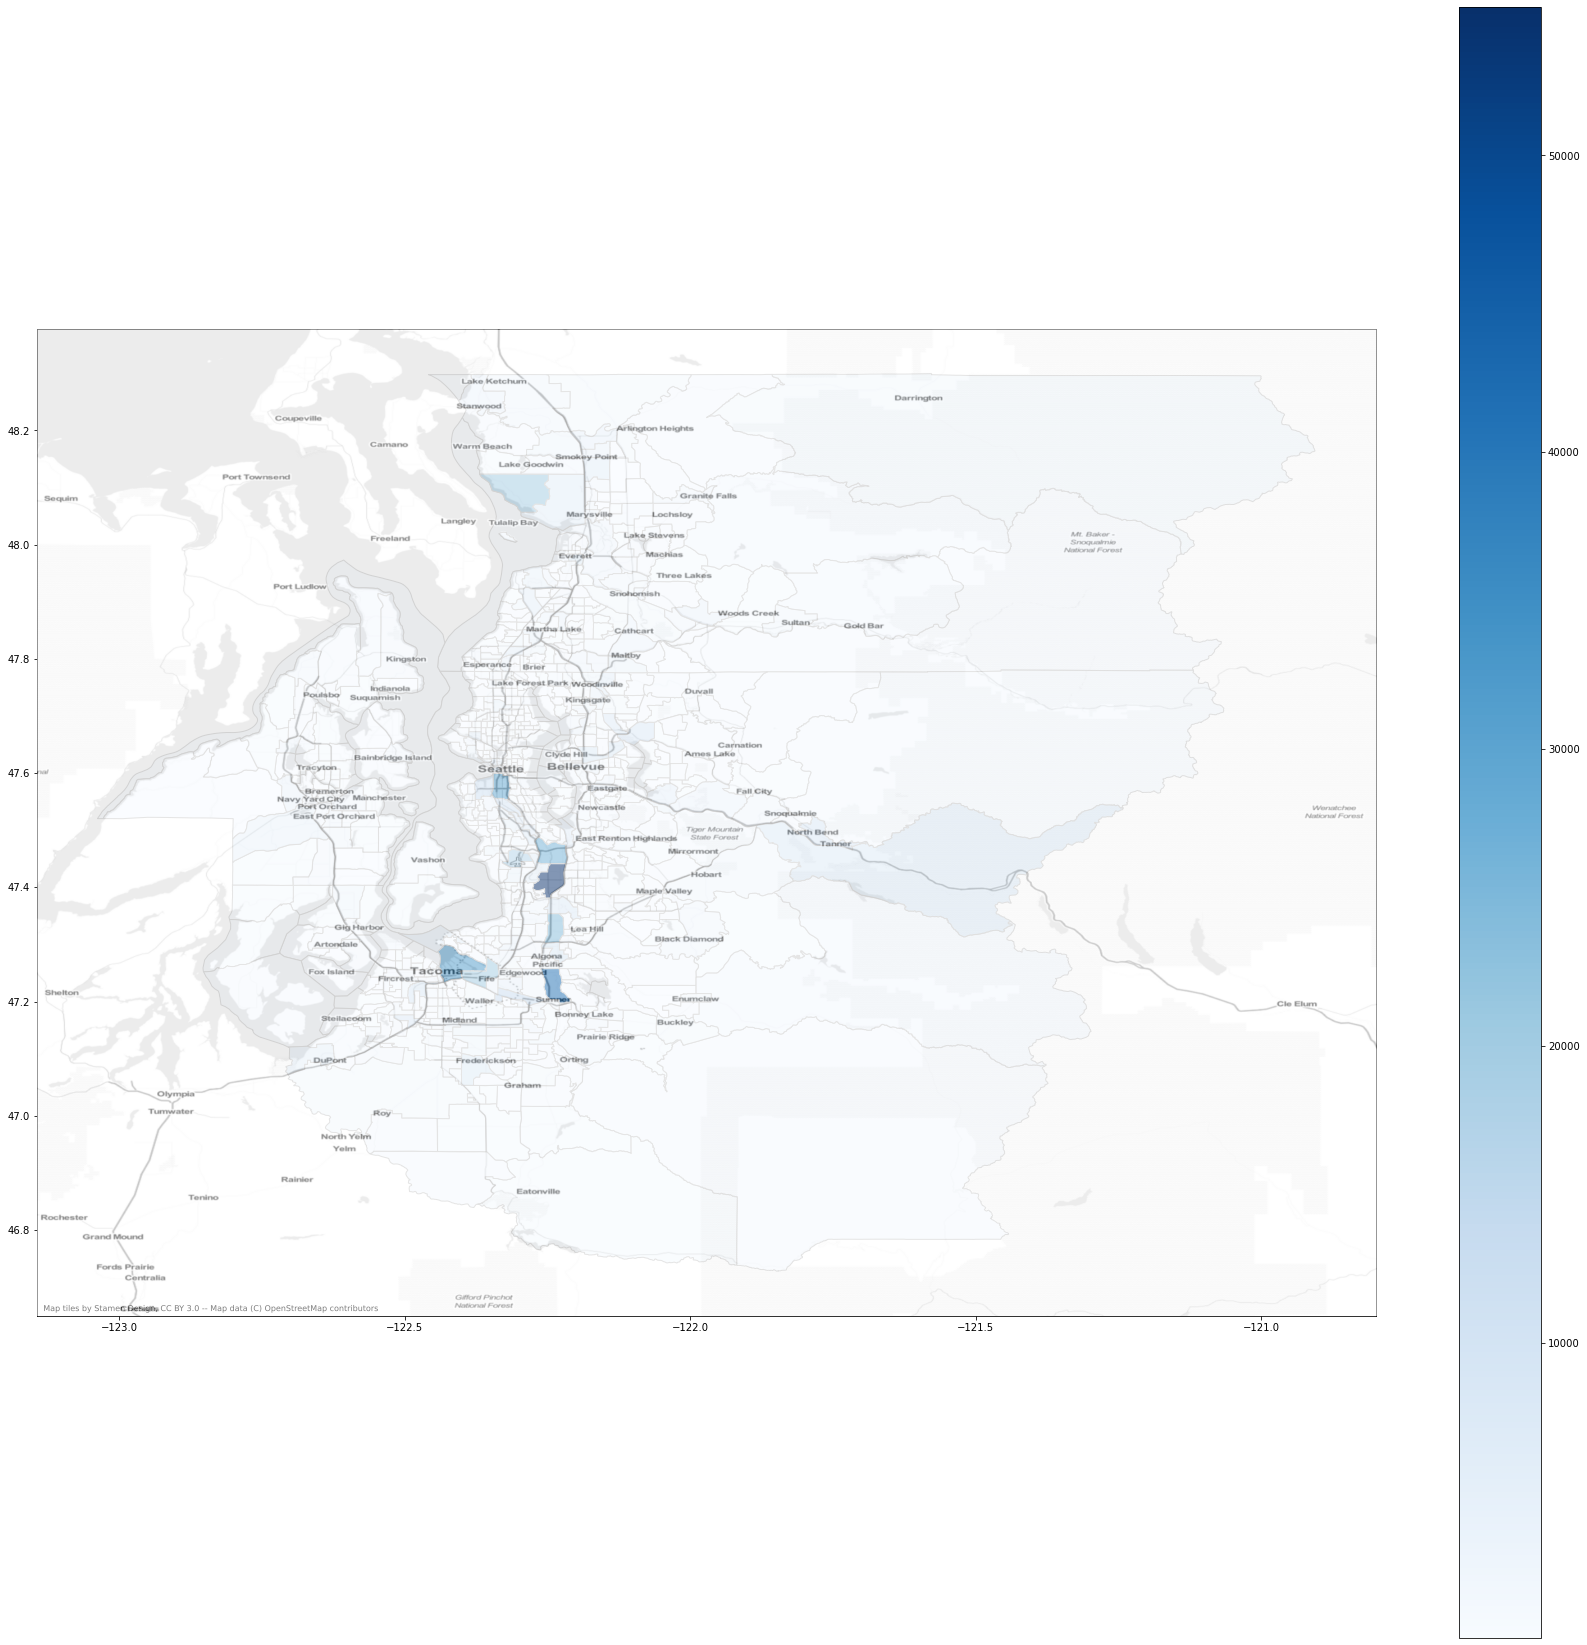

In [55]:
variable = 'count'
# set the range for the choropleth
vmin, vmax = 50, 55000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 30))
# create map
d_by_tract_count.plot(column='count', cmap='Blues', ax=ax,  edgecolor='0.8')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=10, alpha=0.5, zorder=8 , crs='EPSG:4326' )


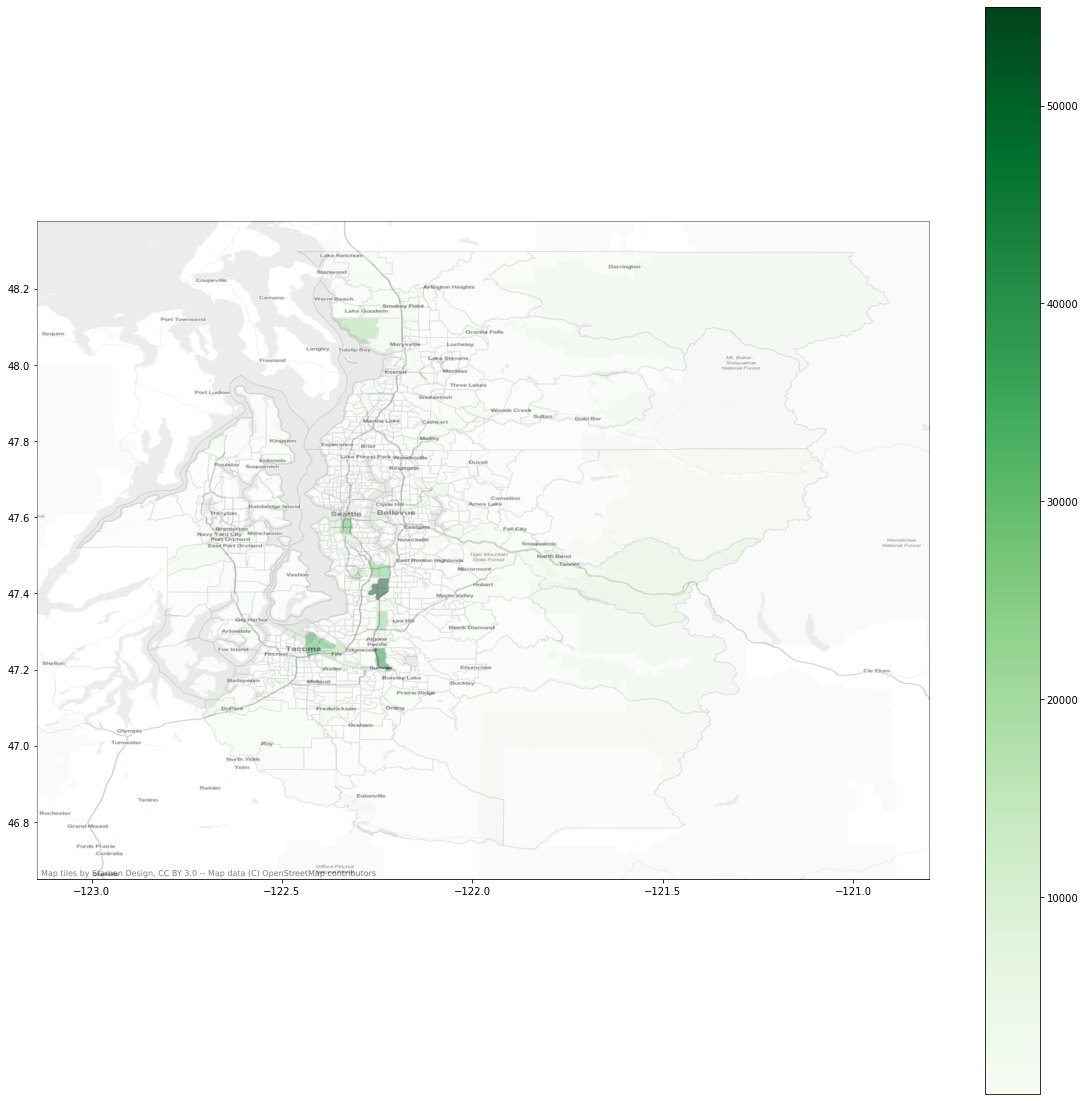

In [119]:
variable = 'count'
# set the range for the choropleth
vmin, vmax = 50, 55000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 20))
# create map
o_by_tract_count.plot(column='count', cmap='Greens', ax=ax,  edgecolor='0.8')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=10, alpha=0.5, zorder=8 , crs='EPSG:4326' )

In [159]:
geosource = GeoJSONDataSource(geojson = o_by_tract_count.to_crs(3857).to_json())
output_file("C:/Users/pbutrina/Documents/o_by_tract_may2019.html")
# Define color palettes
#tile_provider = get_provider(Vendors.STAMEN_TONER)
tile_provider = get_provider(Vendors.OSM)
palette = brewer['BuGn'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 50000)
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1,000', '5000':'5,000',
 '10000':'10,000', '20000':'20,000',
 '30000':'30,000', '50000':'30,000+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p = figure(title = 'Truck Origins Grouped by Census Tract, May 2019', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,fill_alpha=0.6,
                   fill_color = {'field':'count',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25)
# Create hover tool
p.add_tools(HoverTool(renderers = [states],
                     tooltips = [('Tract','@tractce10'),
                               ('count', '@count')]))
# Specify layout
p.add_layout(color_bar, 'below')
p.add_tile(tile_provider)
show(p)

In [84]:
geosource = GeoJSONDataSource(geojson = d_by_tract_count.to_crs(3857).to_json())
output_file("C:/Users/pbutrina/Documents/d_by_tract_may2019.html")
# Define color palettes
#tile_provider = get_provider(Vendors.STAMEN_TONER)
tile_provider = get_provider(Vendors.OSM)
palette = brewer['OrRd'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 50000)
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1,000', '5000':'5,000',
 '10000':'10,000', '20000':'20,000',
 '30000':'30,000', '50000':'30,000+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p = figure(title = 'Truck Destinations Grouped by Census Tract, May 2019', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,fill_alpha=0.6,
                   fill_color = {'field':'count',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25)
# Create hover tool
p.add_tools(HoverTool(renderers = [states],
                     tooltips = [('Tract','@tractce10'),
                               ('count', '@count')]))
# Specify layout
p.add_layout(color_bar, 'below')
p.add_tile(tile_provider)
show(p)

In [81]:
geosource = GeoJSONDataSource(geojson = o_by_tract_count_2015.to_crs(3857).to_json())
output_file("C:/Users/pbutrina/Documents/o_by_tract_may2015.html")
# Define color palettes
#tile_provider = get_provider(Vendors.STAMEN_TONER)
tile_provider = get_provider(Vendors.OSM)
palette = brewer['BuGn'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 50000)
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1,000', '5000':'5,000',
 '10000':'10,000', '20000':'20,000',
 '30000':'30,000', '50000':'30,000+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p = figure(title = 'Truck Origins Grouped by Census Tract, May 2015', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,fill_alpha=0.6,
                   fill_color = {'field':'count',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25)
# Create hover tool
p.add_tools(HoverTool(renderers = [states],
                     tooltips = [('Tract','@tractce10'),
                               ('count', '@count')]))
# Specify layout
p.add_layout(color_bar, 'below')
p.add_tile(tile_provider)
show(p)

In [83]:
geosource = GeoJSONDataSource(geojson = d_by_tract_count_2015.to_crs(3857).to_json())
output_file("C:/Users/pbutrina/Documents/d_by_tract_may2015.html")
# Define color palettes
#tile_provider = get_provider(Vendors.STAMEN_TONER)
tile_provider = get_provider(Vendors.OSM)
palette = brewer['OrRd'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 50000)
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '500': '500',
 '1000':'1,000', '5000':'5,000',
 '10000':'10,000', '20000':'20,000',
 '30000':'30,000', '50000':'30,000+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p = figure(title = 'Truck Destinations Grouped by Census Tract, May 2015', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,fill_alpha=0.6,
                   fill_color = {'field':'count',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25)
# Create hover tool
p.add_tools(HoverTool(renderers = [states],
                     tooltips = [('Tract','@tractce10'),
                               ('count', '@count')]))
# Specify layout
p.add_layout(color_bar, 'below')
p.add_tile(tile_provider)
show(p)

In [93]:
geosource = GeoJSONDataSource(geojson = d_by_uc_count.to_crs(3857).to_json())
output_file("C:/Users/pbutrina/Documents/d_by_uc_may2019.html")
# Define color palettes
tile_provider = get_provider(Vendors.CARTODBPOSITRON)
#tile_provider = get_provider(Vendors.OSM)
palette = brewer['OrRd'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 23000)
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '800': '800',
 '2000':'2,000', '3000':'3,000',
 '4000':'4,000', '5000':'5,000',
 '10000':'10,000', '23000':'10,000+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p = figure(title = 'Truck Destinations Grouped by Urban Centers, May 2019', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,fill_alpha=0.6,
                   fill_color = {'field':'count',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25)
# Create hover tool
p.add_tools(HoverTool(renderers = [states],
                     tooltips = [('Name','@name'),
                               ('count', '@count')]))
# Specify layout
p.add_layout(color_bar, 'below')
p.add_tile(tile_provider)
show(p)

In [95]:
geosource = GeoJSONDataSource(geojson = o_by_uc_count.to_crs(3857).to_json())
output_file("C:/Users/pbutrina/Documents/o_by_uc_may2019.html")
# Define color palettes
#tile_provider = get_provider(Vendors.STAMEN_TONER)
tile_provider = get_provider(Vendors.CARTODBPOSITRON)
palette = brewer['Reds'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 23000)
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '800': '800',
 '2000':'2,000', '3000':'3,000',
 '4000':'4,000', '5000':'5,000',
 '10000':'10,000', '23000':'10,000+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)
# Create figure object.
p = figure(title = 'Truck Origins Grouped by Urban Centers, May 2019', 
           plot_height = 600, plot_width = 950, 
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,fill_alpha=0.6,
                   fill_color = {'field':'count',
                                 'transform' : color_mapper},
                   line_color = 'gray', 
                   line_width = 0.25)
# Create hover tool
p.add_tools(HoverTool(renderers = [states],
                     tooltips = [('Name','@name'),
                               ('count', '@count')]))
# Specify layout
p.add_layout(color_bar, 'below')
p.add_tile(tile_provider)
show(p)